# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2021

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por
$$\pi(a \mid s) = 1 - \epsilon$$ si $a$ es la mejor acción, caso contrario $$\pi(a \mid s) = \epsilon$$

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/sarsa.png?raw=1)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/q_learning.png?raw=1)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Librería OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee cinco métodos principales:

* ```reset(self)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, done, info```.el done nos dice si termino o no el episodio en forma de bandera (el estado es el final). 

* ```render(self)``` : Muestra en pantalla una parte del ambiente. permite mostrar simulaciones del entorno. En test veo como actua el agente. 

* ```close(self)``` : Finaliza con la instancia del agente.

* ```seed(self)``` : Establece la semilla aleatoria del generador de números aleatorios del presente entorno. 


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas. nos dice q acciones puedo hacer.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones. normalmente no se sabe. que tan grande son la cantidad de observaciones. nos dicen un rango.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible que devuelve el entorno.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```apt-get install ffmpeg```

desde Mac, reemplazar *apt-get* por *brew*

desde Windows, descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

Código básico de importación y funciones de graficación (no modificar)

In [ ]:
#@title Código básico de graficación (no modificar)

import numpy as np
import matplotlib.pyplot as plt
import itertools
import gym

def plot_reward_per_episode(reward_ep):

    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

    plt.plot(reward_per_episode)
    plt.title('Recompensa acumulada por episodio')
    plt.show()
    
    
def plot_steps_per_episode(timesteps_ep):
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title('Pasos (timesteps) por episodio')
    plt.show()
    
    
def plot_steps_per_episode_smooth(timesteps_ep):
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [acumulated_steps[i] / episode_number[i] for i in range(len(acumulated_steps))]

    plt.plot(steps_per_episode)
    plt.title('Pasos (timesteps) acumulados por episodio')
    plt.show()
    

def draw_value_matrix(q):

    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):

            state_values = []

            for action in range(n_actions):
                state_values.append(q.get((row * n_columns + column, action), -100))

            maximum_value = max(state_values)  # determinamos la acción que arroja máximo valor


            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar) para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])):

        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = 'D'
        best_action = down_action

        if best_action < right_action:
            arrow_direction = 'R'
            best_action = right_action
        if best_action < left_action:
            arrow_direction = 'L'
            best_action = left_action
        if best_action < up_action:
            arrow_direction = 'U'
            best_action = up_action
        if best_action == -1:
            arrow_direction = ''

        # notar que column, row están invertidos en orden en la línea de abajo porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print('\n Matriz de mejor acción-valor (en números): \n\n', q_value_matrix)

Ejemplo: agente CartPole. Tiene recompensa continua. +1 si no se cae la barra

In [ ]:
import gym
import time
from IPython.display import clear_output

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# no es posible mostrar videos de ejecución del agente desde Colab
if not IN_COLAB:

    env = gym.make('CartPole-v0') #crea el entorno cartpole
    env.reset()
    for _ in range(500): #500 pasos de tiempo
        env.render(mode='human')
        observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
        if done:
            env.reset()
    env.close()
    clear_output()

Ejemplo: agente Mountain Car

In [ ]:
if not IN_COLAB:
    env = gym.make('MountainCar-v0')
    observation = env.reset()
    for t in range(500):
        env.render(mode='human')
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()
    clear_output()

## Ejemplo 1: The Cliff. 


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal
la meta no da recompensa, aunque si da recompensa negativa por cada paso q da, aunque si cae al risco vuelve al estado inicial y tiene recompensa -100.
(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [ ]:
def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy

    dado un estado elige una accion, usando epsilon greedy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]  # ej: para 4 acciones inicializa en [0,0,0,0]
    # viene de un diccionario que se declara mas abajo y se llenan cuando se explora
    #obtiene los valores de q para cada accion
    max_q = max(q_values)
    #al ser epsilon gredy pregunta cual es el q maximo

    if random_state.uniform() < epsilon:  # sorteamos un número entre 0 y 1: es menor a épsilon?
        return random_state.choice(actions)  # sí: se selecciona una acción aleatoria para explorar
        #para softmax tengo que definir probabilidad de cada accion y ponerle que si el valor cae entre 0 y 0.25 haga A , entre 0.25 y 0.5 haga B y asi..
  
  #si no es aleatorio hago explotacion        

    count = q_values.count(max_q) #si hay varias q optimas las cuento y me fijo:

    
    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        #esto sirve al principuo donde todos los q son similares
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        #si es una sola accion optima la elijo
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [ ]:
def learn_sarsa(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """
    
    # Si se hace bien converge el agente
    #q.get([state,action], 0.0) = q[state,action] + alpha * (reward + (gamma * q[next_state,next_action])-q[state,action])

    q[(state,action)] = q.get((state,action),0) + alpha * (reward + (gamma * q.get((next_state,next_action),0))-q.get((state,action),0))
    
    pass

In [ ]:
def learn_qlearning(state, action, reward, next_state, next_action):
    """
    Performs a q-learning update for a given state transition
    """
    
    # Si se hace bien converge el agente
    q[(state,action)] = q.get((state,action),0) + alpha * (reward + (gamma * q.get((next_state,np.argmax(q.get(next_action))),0))-q.get((state,action),0))

    #q[state,action] = q.get((state,action),0) + alpha * (reward + (gamma * 
     #   q.get((next_state,max( (k1 for (k0,k1), value in q.items() if k0== int(next_state)),default = 0)),0)))-q.get((state,action),0)
    
    pass

Finalmente, definimos el método principal de iteraciones. 

In [ ]:
def run_sarsa():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    timesteps_of_episode = []  # registro de la cantidad de pasos que le llevó en cada episodio
    reward_of_episode = []  # cantidad de recompensa que recibió el agente en cada episodio

    for i_episode in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo llega a la salida
        # o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state = env.reset()

        episode_reward = 0
        done = False #si termina da True
        t = 0 #cantidad de pasos

        # elige una acción basado en el estado actual
        action = choose_action(state)
        
        while not done:

            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)
            

            episode_reward += reward
            learn_sarsa(state, action, reward, next_state, next_action)

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                state = next_state
                action = next_action #aca le digo q sea on-policy
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode
    #metricas para evaluar la convergencia

In [ ]:
def run_qlearning():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    timesteps_of_episode = []  # registro de la cantidad de pasos que le llevó en cada episodio
    reward_of_episode = []  # cantidad de recompensa que recibió el agente en cada episodio

    for i_episode in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo llega a la salida
        # o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state = env.reset()

        episode_reward = 0
        done = False #si termina da True
        t = 0 #cantidad de pasos

        # elige una acción basado en el estado actual
        action = choose_action(state)
        
        while not done:

            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, done, info = env.step(action)
            
            next_action =  choose_action(next_state)
            

            episode_reward += reward
            learn_qlearning(state, action, reward, next_state, next_action)

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                state = next_state
                action = next_action #aca le digo q sea on-policy
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode
    #metricas para evaluar la convergencia

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [ ]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1 #tiene q ser menor q 1 por lo gral
epsilon = 0.1
tau = 25 #va de 0 a infinito

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

## Sarsa

In [ ]:
avg_steps_per_episode, timesteps_ep, reward_ep = run_sarsa()

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

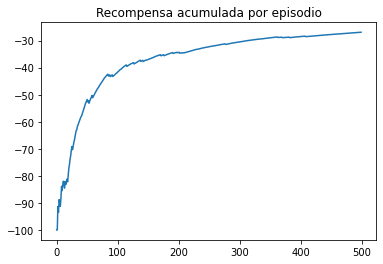

In [ ]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

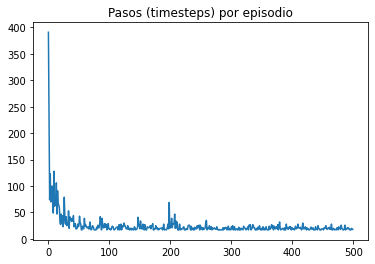

In [ ]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

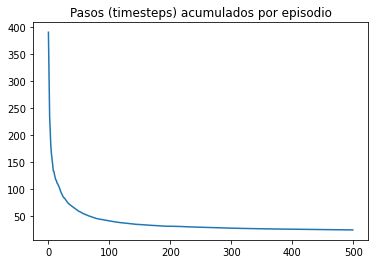

In [ ]:
plot_steps_per_episode_smooth(timesteps_ep)
#el primer paso se da porq divide por un promedio alto

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

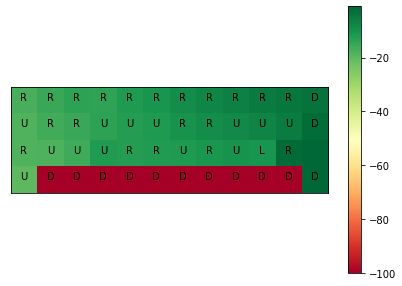


 Matriz de mejor acción-valor (en números): 

 [[ -17.23954428  -15.14316652  -13.47940719  -13.86734791  -11.50591433
   -10.42824021   -8.92910114   -7.36906975   -6.09772006   -5.02260286
    -4.246717     -3.48743802]
 [ -18.17688817  -16.29163152  -15.09887514  -13.57191616  -12.57200446
   -11.46204211  -10.28051994   -8.75636874   -8.02140089   -7.17268501
    -5.41325753   -2.24362335]
 [ -18.16818774  -17.96726471  -16.02741607  -12.12753358  -12.36502775
   -11.94064567  -11.56233996  -10.96253903   -9.96154144  -10.28531687
    -2.00258599   -1.        ]
 [ -19.72790699 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [ ]:
draw_value_matrix(q)
#veo cual es la politica optima.
#al variar los hiperparametros va a cambiar el coloreado de cada accion

In [ ]:
env.close()

## Q-learning

In [ ]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1 #tiene q ser menor q 1 por lo gral
epsilon = 0.1
tau = 25 #va de 0 a infinito

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [ ]:
avg_steps_per_episode, timesteps_ep, reward_ep = run_qlearning()

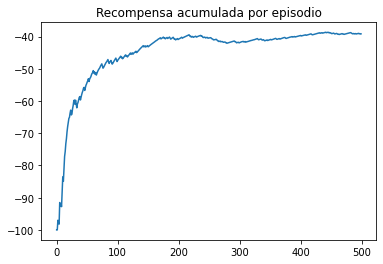

In [ ]:
plot_reward_per_episode(reward_ep)

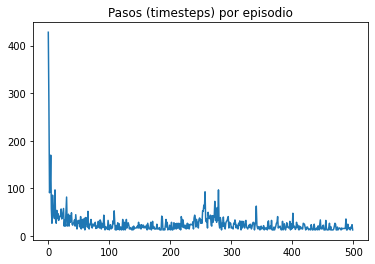

In [ ]:
plot_steps_per_episode(timesteps_ep)

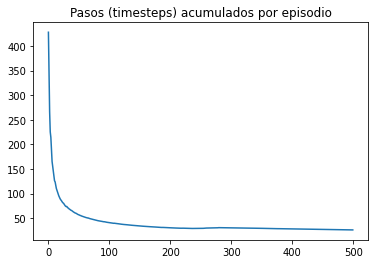

In [ ]:
plot_steps_per_episode_smooth(timesteps_ep)


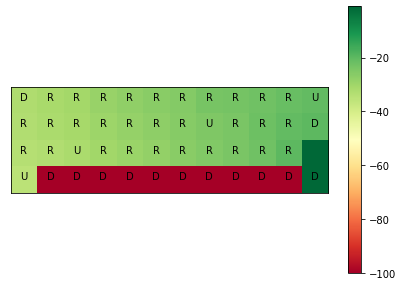


 Matriz de mejor acción-valor (en números): 

 [[ -32.34678058  -31.4276003   -30.45115611  -28.49877905  -27.49972533
   -26.49999142  -25.43748283  -23.4999994   -23.36718744  -22.46044921
   -21.37109373  -20.5       ]
 [ -32.72251746  -31.77394945  -30.84385672  -29.33580959  -28.29083967
   -27.07181511  -25.81609005  -24.82139168  -23.83709725  -22.07277448
   -20.43742179  -19.6605126 ]
 [ -33.7717897   -32.74972967  -31.75135092  -30.23508739  -29.10827881
   -27.79212309  -26.30543877  -25.17733697  -23.82260299  -22.56364833
   -19.83362203   -1.        ]
 [ -34.97143687 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [ ]:
draw_value_matrix(q)


## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

### Hiperparametros



Se realizara una variacion de hiperparametros solo para el metodo SARSA por simplicidad. Luego se evaluara cada uno, manteniendo los otros dos hiperparametros constantes.


hiperparametros usados: 
alpha  0.01
gamma  0.2
epsilon  0.005


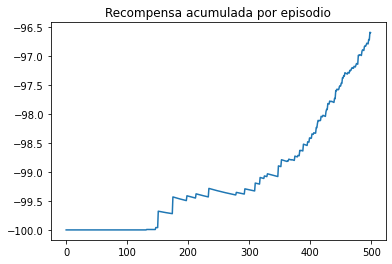

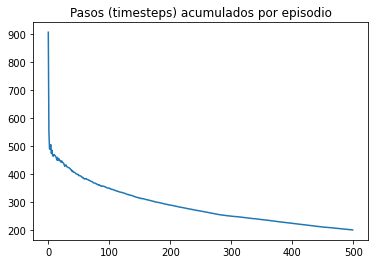

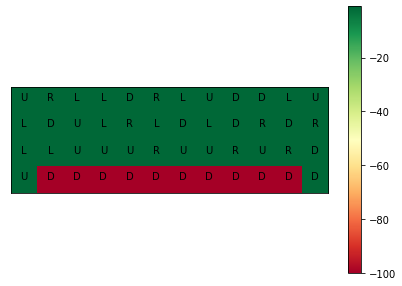


 Matriz de mejor acción-valor (en números): 

 [[  -1.24964355   -1.24957447   -1.24944801   -1.24908268   -1.24852281
    -1.24758572   -1.24594361   -1.243053     -1.23778468   -1.22809828
    -1.21183815   -1.19313256]
 [  -1.24970127   -1.24960667   -1.24957686   -1.24902097   -1.24850737
    -1.24758807   -1.24596291   -1.24297656   -1.23725568   -1.225962
    -1.20219831   -1.16225943]
 [  -1.24980474   -1.2495547    -1.24981269   -1.24805108   -1.24857468
    -1.24761122   -1.2459449    -1.24292827   -1.23656502   -1.22325154
    -1.1775387    -0.99342952]
 [  -1.24992546 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]

hiperparametros usados: 
alpha  0.01
gamma  0.2
epsilon  0.8


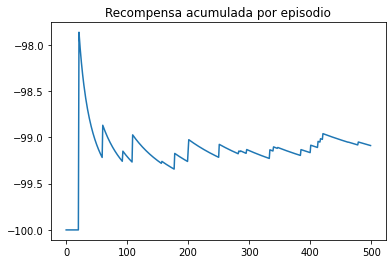

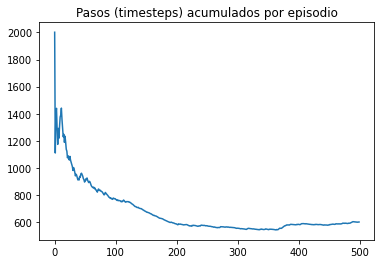

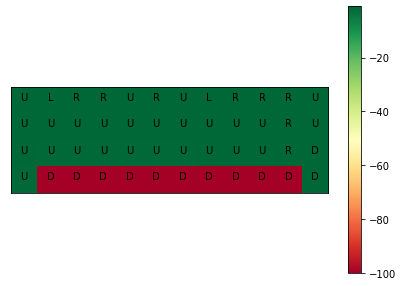


 Matriz de mejor acción-valor (en números): 

 [[  -1.25121285   -1.25143478   -1.26012353   -1.25851263   -1.25891398
    -1.25683232   -1.25597103   -1.25560644   -1.25568436   -1.25605371
    -1.25033764   -1.25034229]
 [  -1.25154429   -1.25912289   -1.26076658   -1.26041707   -1.25954971
    -1.25815906   -1.2575117    -1.2570186    -1.25503645   -1.25510831
    -1.25174501   -1.24970271]
 [  -1.27364296   -1.43599353   -1.4191302    -1.48298547   -1.40404593
    -1.4153627    -1.39504554   -1.31146201   -1.32670985   -1.27673498
    -1.2043017    -0.99146738]
 [  -1.60906334 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]

hiperparametros usados: 
alpha  0.01
gamma  1
epsilon  0.005


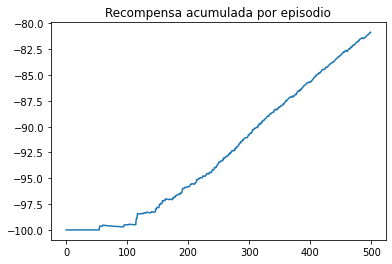

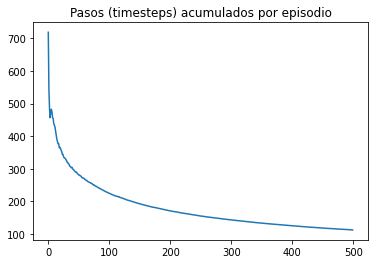

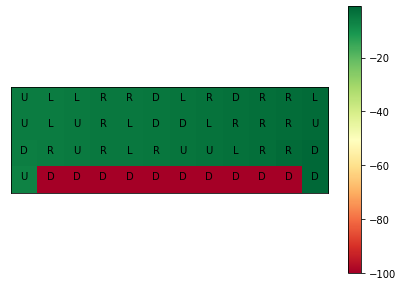


 Matriz de mejor acción-valor (en números): 

 [[  -5.41232076   -5.27439942   -5.06000219   -4.80120112   -4.5126872
    -4.20452006   -3.87398483   -3.52178602   -3.15073839   -2.76648809
    -2.38755739   -2.10148527]
 [  -5.55628742   -5.35034982   -5.09377109   -4.81612123   -4.51780014
    -4.20183417   -3.86555659   -3.50916359   -3.11711207   -2.68857588
    -2.22032413   -1.77000947]
 [  -5.87403733   -5.47186653   -5.14006552   -4.83362354   -4.52347996
    -4.19716846   -3.85080423   -3.48856813   -3.06780436   -2.56450339
    -1.88838178   -0.99342952]
 [  -6.42890394 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]

hiperparametros usados: 
alpha  0.01
gamma  1
epsilon  0.8


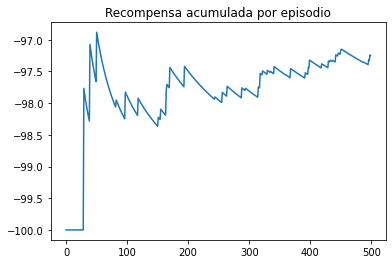

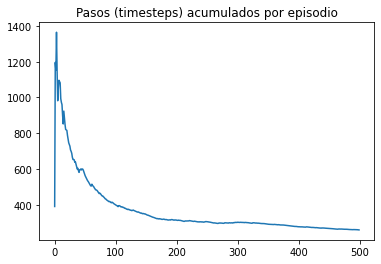

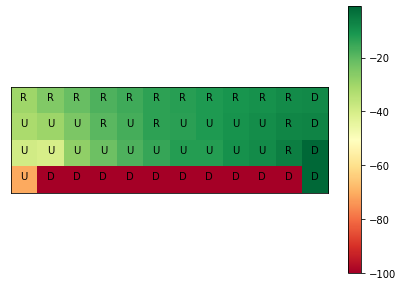


 Matriz de mejor acción-valor (en números): 

 [[ -29.97829992  -25.10715348  -21.21103799  -17.95736364  -15.69654951
   -13.53574256  -12.76832307  -11.47510041  -10.40809728   -9.58034139
    -8.4313604    -7.9939844 ]
 [ -31.62944253  -29.48159611  -24.25191393  -19.32026387  -16.81501772
   -13.73386343  -13.02390944  -11.48994612  -10.07960519   -9.02281262
    -7.47572117   -7.04482094]
 [ -39.27876637  -40.21390645  -27.63864716  -22.07532631  -17.94288494
   -14.71549676  -12.27919585  -12.21459888   -9.63486509   -8.36646774
    -5.9883013    -0.99322839]
 [ -70.71197456 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]

hiperparametros usados: 
alpha  0.9
gamma  0.2
epsilon  0.005


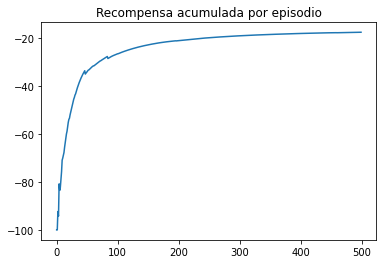

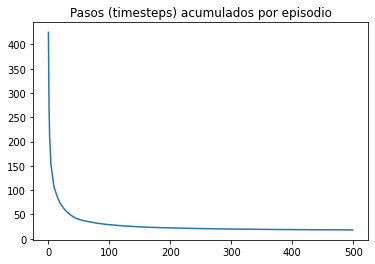

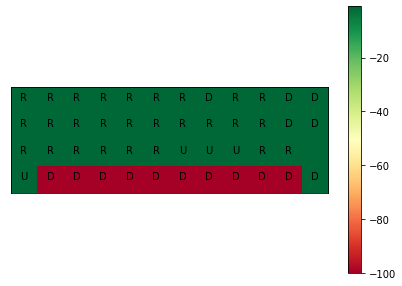


 Matriz de mejor acción-valor (en números): 

 [[  -1.25         -1.25         -1.24999999   -1.24999996   -1.24999983
    -1.24999929   -1.24999671   -1.24998385   -1.24991998   -1.24959999
    -1.248        -1.24      ]
 [  -1.25         -1.25         -1.25         -1.24999998   -1.24999947
    -1.24999683   -1.249984     -1.24992      -1.2496       -1.248
    -1.24         -1.2       ]
 [  -1.25         -1.25         -1.25         -1.24999998   -1.24999987
    -1.24999936   -1.2499968    -1.24998743   -1.24998777   -1.24
    -1.2          -1.        ]
 [  -1.25       -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]

hiperparametros usados: 
alpha  0.9
gamma  0.2
epsilon  0.8


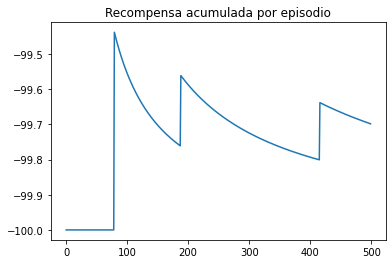

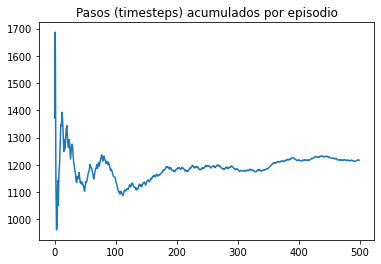

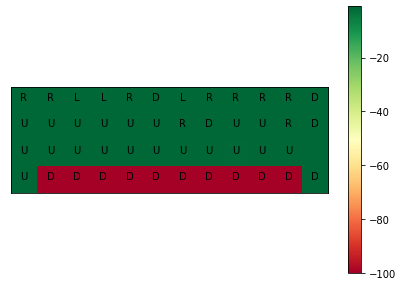


 Matriz de mejor acción-valor (en números): 

 [[  -1.25000108   -1.25019293   -1.25000419   -1.25037651   -1.25040974
    -1.25017322   -1.2500361    -1.255549     -1.2504635    -1.25105834
    -1.24965863   -1.24998987]
 [  -1.25019255   -1.25000249   -1.25007252   -1.25007153   -1.2517385
    -1.25008353   -1.25477993   -1.26953408   -1.25231467   -1.25391395
    -1.2500022    -1.20499572]
 [  -1.25265786   -1.25159246   -1.250774     -1.25067072   -1.25550184
    -1.25209651   -1.27100508   -1.25417236   -1.5769258    -1.25133589
    -1.2500171    -1.        ]
 [  -1.25698533 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]

hiperparametros usados: 
alpha  0.9
gamma  1
epsilon  0.005


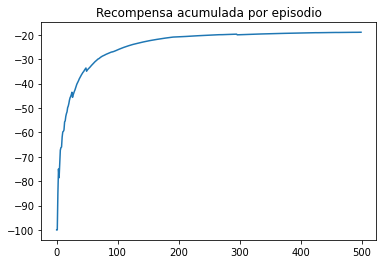

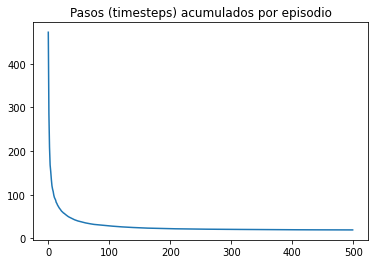

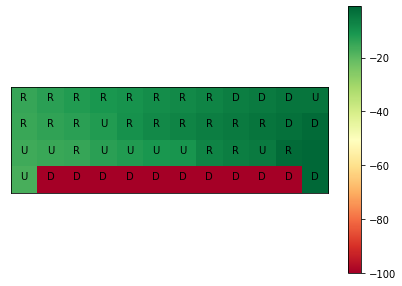


 Matriz de mejor acción-valor (en números): 

 [[ -14.58728767  -13.22906034  -12.02108601  -11.          -10.
    -9.           -8.           -7.           -6.           -5.
    -4.           -3.75651   ]
 [ -15.00000315  -14.00000014  -13.          -12.           -9.5780891
    -8.0640198    -7.00244554   -6.           -5.           -4.
    -3.           -2.        ]
 [ -16.00004949  -15.18292797  -14.80373594  -13.27410566  -12.
   -10.77418163  -10.39897886   -7.           -6.           -5.
    -2.           -1.        ]
 [ -17.00055057 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]

hiperparametros usados: 
alpha  0.9
gamma  1
epsilon  0.8


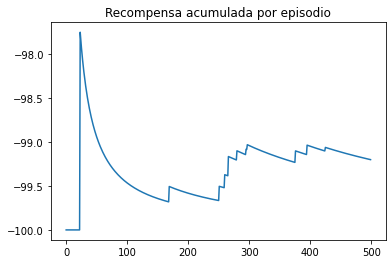

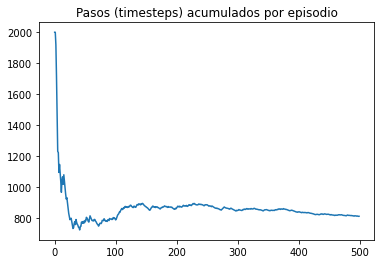

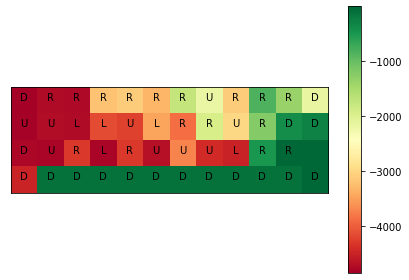


 Matriz de mejor acción-valor (en números): 

 [[-4.84514108e+03 -4.72957054e+03 -4.74153895e+03 -3.18593731e+03
  -3.09900650e+03 -3.30037210e+03 -1.73682408e+03 -2.16275559e+03
  -3.09958092e+03 -8.25932225e+02 -1.34754380e+03 -2.14565929e+03]
 [-4.82350947e+03 -4.69678788e+03 -4.72621133e+03 -4.13954295e+03
  -4.20575647e+03 -3.44880198e+03 -3.86462098e+03 -1.92570998e+03
  -2.98383700e+03 -1.20007617e+03 -3.93644206e+02 -2.68970336e+02]
 [-4.75867520e+03 -4.78294691e+03 -4.28026580e+03 -4.77406792e+03
  -4.29255182e+03 -4.66291734e+03 -3.70366643e+03 -4.42784395e+03
  -4.50390400e+03 -4.75794460e+02 -5.49018250e+00 -1.00000000e+00]
 [-4.46845252e+03 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
  -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
  -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+00]]


In [ ]:
#Hiperparametros a variar
alpha_list=[0.01,0.9]
gamma_list=[0.2,1]
epsilon_list=[0.005,0.8]
for i in alpha_list:
  for j in gamma_list:
    for k in epsilon_list:
      q = {}
      alpha = i
      gamma = j #tiene q ser menor q 1 por lo gral
      epsilon = k
      
      episodes_to_run = 500

      env = gym.make("CliffWalking-v0")
      actions = range(env.action_space.n)

      # se declara una semilla aleatoria
      random_state = np.random.RandomState(42)
      avg_steps_per_episode, timesteps_ep, reward_ep = run_sarsa()

      print()
      print('hiperparametros usados: ')
      print('alpha ', i)
      print('gamma ', j)
      print('epsilon ', k)
      plot_reward_per_episode(reward_ep)
      plot_steps_per_episode_smooth(timesteps_ep)
      draw_value_matrix(q)
      env.close()

Conclusiones de hiperparametros:
- El alpha modifica la cantidad de pasos necesarios que va a necesitar para lograr el aprendizaje. Se puede ver como los valores con alpha 0.9 decrece mas rapido la cantidad de pasos acumulados.
- el gamma modifica  la cantidad de pasos necesarios que va a necesitar para lograr el aprendizaje. Se puede ver como los valores con gamma 1 decrece mas rapido la cantidad de pasos acumulados. Aunque tambien disminuyen los valores de q en la matriz.
- el epsilon modifica  la recompensa acumulada que logra en el aprendizaje. Se puede ver como los valores con epsilon 0.005 logra mayores recompensas acumuladas. A su vez tambien  modifica  la cantidad de pasos necesarios que va a necesitar para lograr el aprendizaje. Se puede ver como los valores con epsilon mas pequeños logra decrecer mas rapido la cantidad de pasos acumulados. Por ultimo tambien epsilon pequños disminuye la matriz q logrando mejores resultados. Sin embargo si se usa un epsilon muy bajo y el ambiente cambia nunca a explorar y por ende lo que aprendio va a ser erroneo en un ambiente distinto.

FIN